This is a beginner exercise in PyTorch. We fit a Linear Regression model to predict 'subscription days' for customers.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-churn/data.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df = pd.read_csv('../input/customer-churn/data.csv')
df.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2015,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2015,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2015,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2015,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2015,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


In [5]:
df.shape

(2000, 16)

In [6]:
# Removing irrelevant columns

df = df.drop(['year', 'customer_id', 'phone_no'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  1976 non-null   object 
 1   age                     2000 non-null   int64  
 2   no_of_days_subscribed   2000 non-null   int64  
 3   multi_screen            2000 non-null   object 
 4   mail_subscribed         2000 non-null   object 
 5   weekly_mins_watched     2000 non-null   float64
 6   minimum_daily_mins      2000 non-null   float64
 7   maximum_daily_mins      2000 non-null   float64
 8   weekly_max_night_mins   2000 non-null   int64  
 9   videos_watched          2000 non-null   int64  
 10  maximum_days_inactive   1972 non-null   float64
 11  customer_support_calls  2000 non-null   int64  
 12  churn                   1965 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 203.2+ KB


In [8]:
(100*df.isnull().sum())/len(df)

gender                    1.20
age                       0.00
no_of_days_subscribed     0.00
multi_screen              0.00
mail_subscribed           0.00
weekly_mins_watched       0.00
minimum_daily_mins        0.00
maximum_daily_mins        0.00
weekly_max_night_mins     0.00
videos_watched            0.00
maximum_days_inactive     1.40
customer_support_calls    0.00
churn                     1.75
dtype: float64

In [9]:
# Dropping all null rows

df.dropna(inplace=True)
df.shape

(1918, 13)

In [10]:
# Label Encoding selected columns

le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['multi_screen'] = le.fit_transform(df['multi_screen'])
df['mail_subscribed'] = le.fit_transform(df['mail_subscribed'])

<Axes: >

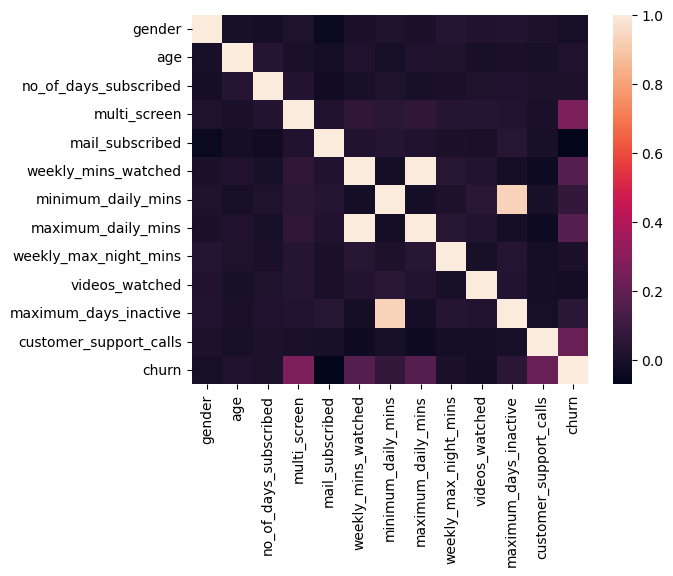

In [11]:
# Checking correlations of features with target label

sns.heatmap(df.corr())

With 'no_of_days_subscribed', all other features appear very weakly correlated.

In [12]:
# Separating feature and label vectors

y = df['no_of_days_subscribed']
X = df[[col for col in df.columns if col != 'no_of_days_subscribed']]
X.shape, y.shape

((1918, 12), (1918,))

In [13]:
# Scaling feature dataframe

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = scaler.transform(X)

n_samples, n_features = X.shape

# Converting target series to a numpy array

y = y.to_numpy()

<Axes: ylabel='Density'>

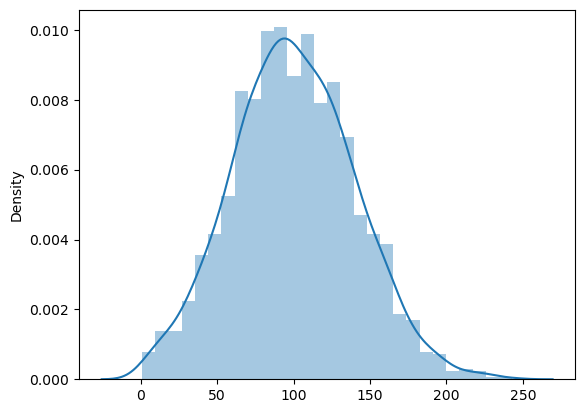

In [14]:
# Checking distribution of target labels

sns.distplot(y)

Target labels approach a gaussian like distribution. We can expect the model to work fine.

In [15]:
# Splitting into train-test sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Converting test-train sets first to numpy floats and then to torch tensors

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
# Reshaping torch tensors for train and test sets

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# Setting input and output dimensions

in_dim = n_features
out_dim = 1

In [17]:
# Creating class for the Linear Regression model

class LinearRegressor(torch.nn.Module):
    
    def __init__(self, in_dim, out_dim):
        
        super(LinearRegressor, self).__init__()
        self.model = torch.nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        
        y_pred = self.model(x)
        
        return y_pred       

In [18]:
# Setting model parameters

model = LinearRegressor(in_dim, out_dim)
epochs = 2500
lr = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
# Training the model and relaying changes in loss

for epoch in range(epochs):
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Logging losses after every 100 epochs
    
    if (epoch+1)%100 == 0:
        
        print(f'epoch: {epoch+1}, loss= {loss.item():.4f}')

epoch: 100, loss= 7187.2266
epoch: 200, loss= 4560.6128
epoch: 300, loss= 3215.8154
epoch: 400, loss= 2589.1738
epoch: 500, loss= 2300.1729
epoch: 600, loss= 2146.3440
epoch: 700, loss= 2043.1255
epoch: 800, loss= 1961.8981
epoch: 900, loss= 1894.0406
epoch: 1000, loss= 1836.6406
epoch: 1100, loss= 1788.2251
epoch: 1200, loss= 1747.7238
epoch: 1300, loss= 1714.2233
epoch: 1400, loss= 1686.8896
epoch: 1500, loss= 1664.9336
epoch: 1600, loss= 1647.5984
epoch: 1700, loss= 1634.1639
epoch: 1800, loss= 1623.9570
epoch: 1900, loss= 1616.3624
epoch: 2000, loss= 1610.8345
epoch: 2100, loss= 1606.9023
epoch: 2200, loss= 1604.1710
epoch: 2300, loss= 1602.3210
epoch: 2400, loss= 1601.0997
epoch: 2500, loss= 1600.3142


In [20]:
# Generating predictions for test data, detaching predictions from graph and converting to numpy array
# Generating R2 Score

y_pred = model(X_test).detach().numpy()
r2_score(y_test, y_pred)

-0.0041201576283382835

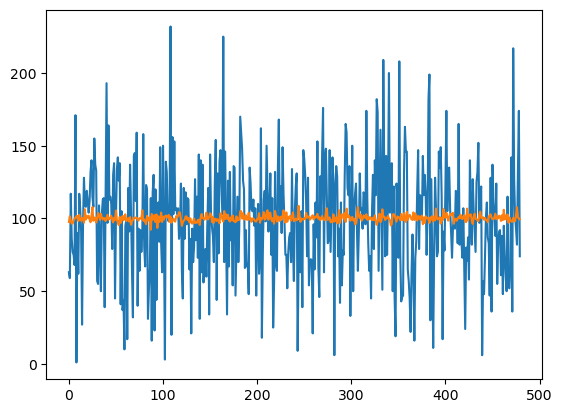

In [21]:
# Comparing predictions with test set

plt.plot(y_test)
plt.plot(y_pred)

The predictions are systematically low. Model hyperparameters need careful tuning.